## Understanding the numpy
### Intro to numpy
* 1. site of numpy http://www.numpy.org/
* 2. Numpy aarray comes to play when need n-dimensional arrays of shape i X j X k ... 
* 3. Numpy is faster because it has C optimized iterators. 



In [43]:
import numpy as np
import array
import matplotlib.pyplot as plt
from pylab import plt,mpl

plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline              

### useful numpy examples 

In [44]:
# 1. deepcopy(v)
# 2. open files 
a = array.array('f',[0,2,4,1])

# this method 1 is same as method 2
f = open('data/array.apy','wb')
a.tofile(f)
f.close()

# method 2
with open('data/array_2.apy','wb') as f:
    a.tofile(f)
f.close()

### Usaful financial data

In [46]:
# check the nasdaq vol 
import pandas as pd
df = pd.read_csv('data/NASDAQCOM.csv',index_col=0,parse_dates=True)
df = df[df.NASDAQCOM != '.']
df = df.astype('float')
df = df[df.index > pd.to_datetime('2018/01/01')]
df = df[df.NASDAQCOM != '.']
df = df.astype('float')
# df = df.join(dfdj)
# df.index
df['return_nasdaq'] = np.log(df/df.shift())
df.dropna(inplace=True)

dfdj = pd.read_csv('data/DJIA.csv',index_col=0,parse_dates=True)
dfdj = dfdj[dfdj.DJIA != '.']
dfdj = dfdj.astype('float')
dfdj['return_dji'] = np.log(dfdj/dfdj.shift())
df = df.join(dfdj)

<AxesSubplot:xlabel='DATE'>

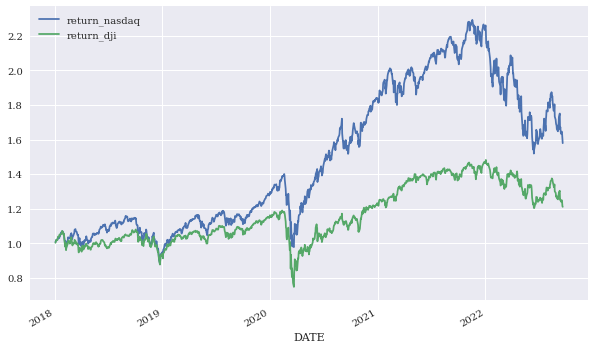

In [47]:
df[['return_nasdaq','return_dji']].cumsum().apply(np.exp).plot(figsize=(10,6))

In [48]:
lags = 6
cols = []
for lag in range(1,lags+1):
    col = 'lag_%s'%lag
    df[col] = np.sign(df['return_nasdaq'].shift(lag))
    cols.append(col)
df.dropna(inplace=True)

In [49]:
from sklearn.svm import SVC 

model = SVC(gamma='auto')
model.fit(df[cols],np.sign(df['return_nasdaq']))

SVC(gamma='auto')

<AxesSubplot:xlabel='DATE'>

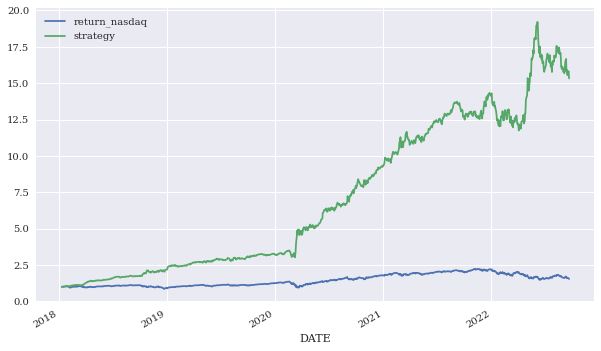

In [50]:
df['prediction'] = model.predict(df[cols])
df['strategy'] = df['prediction']*df['return_nasdaq']
df[['return_nasdaq','strategy']].cumsum().apply(np.exp).plot(figsize=(10,6))

In [51]:
# calculate voltility 

array([<AxesSubplot:xlabel='DATE'>, <AxesSubplot:xlabel='DATE'>,
       <AxesSubplot:xlabel='DATE'>], dtype=object)

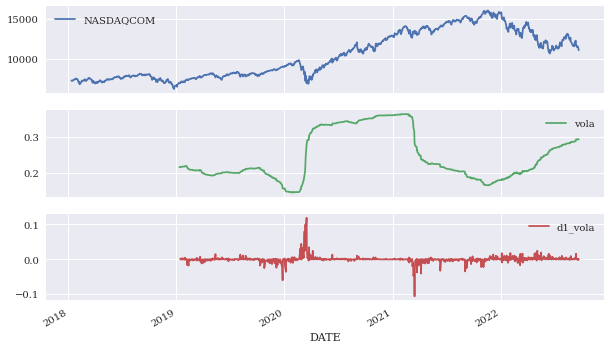

In [52]:
df['vola'] = df['return_nasdaq'].rolling(252).std()*np.sqrt(252)
df['d1_vola'] = (df['vola']-df['vola'].shift(1))/df['vola']
df[['NASDAQCOM','vola','d1_vola']].plot(subplots=True,figsize=(10,6))

array([<AxesSubplot:xlabel='DATE'>, <AxesSubplot:xlabel='DATE'>],
      dtype=object)

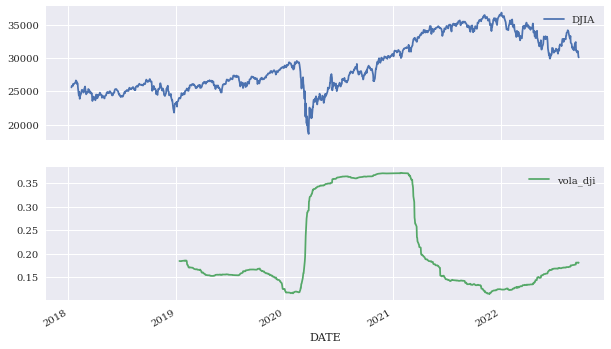

In [53]:
df['vola_dji'] = df['return_dji'].rolling(252).std()*np.sqrt(252)
df[['DJIA','vola_dji']].plot(subplots=True,figsize=(10,6))

### Understand financial time series data 


In [54]:
df.describe().round(2)

,NASDAQCOM,return_nasdaq,DJIA,return_dji,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,prediction,strategy,vola,d1_vola,vola_dji
count,1183.00,1183.00,1183.00,1183.00,1183.00,1183.00,1183.00,1183.00,1183.00,1183.00,1183.00,1183.00,932.00,931.00,932.00
mean,10429.38,0.00,28892.68,0.00,0.11,0.11,0.11,0.11,0.11,0.12,0.42,0.00,0.24,0.00,0.21
std,2871.32,0.02,4055.88,0.01,0.99,0.99,0.99,0.99,0.99,0.99,0.91,0.02,0.07,0.01,0.09
min,6192.92,-0.13,18591.93,-0.14,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-0.08,0.15,-0.11,0.11
25%,7820.60,-0.01,25597.27,-0.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-0.01,0.20,-0.00,0.14
50%,9572.15,0.00,27649.78,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.21,0.00,0.16
75%,13156.68,0.01,32929.98,0.01,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.01,0.32,0.00,0.34
max,16057.44,0.09,36799.65,0.11,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.13,0.36,0.12,0.37


resampling with downsamping to avoide foresight bias.  
Foresight bias is to use the future data with leakage. Make sure to use the right label(index value) and in general the last available data point in the interval. Otherwise, it might cause data leakage.


In [99]:
df.resample('1w',label='right').last().head()

,NASDAQCOM,return_nasdaq,DJIA,return_dji,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,vola_dji,min,max,std,median,mean,ewma,sma1,sma2,position
DATE,,,,,,,,,,,,,,,,,,,,,
2018-01-14,7261.06,0.006810,25803.19,0.008893,1.0,-1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
2018-01-21,7336.38,0.005512,26071.72,0.002070,-1.0,1.0,-1.0,1.0,1.0,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
2018-01-28,7505.77,0.012685,26616.71,0.008448,-1.0,-1.0,1.0,1.0,1.0,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
2018-02-04,7240.95,-0.019815,25520.96,-0.025752,-1.0,1.0,-1.0,-1.0,1.0,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
2018-02-11,6874.49,0.014259,24190.90,0.013754,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1


In [59]:
def overview(df,sym,window=20):
    df['min'] = df[sym].rolling(window=window).min()
    df['max'] = df[sym].rolling(window=window).max()
    df['std'] = df[sym].rolling(window=window).std()
    df['median'] = df[sym].rolling(window=window).median()
    df['mean'] = df[sym].rolling(window=window).mean()
    df['ewma'] = df[sym].ewm(halflife=0.5,min_periods=window).mean()
    ax = df[['min','mean','max']].plot(figsize=(10,6),style=['g--','r--','g--'],lw=0.8)
    df[sym].plot(ax=ax,lw=2.0)

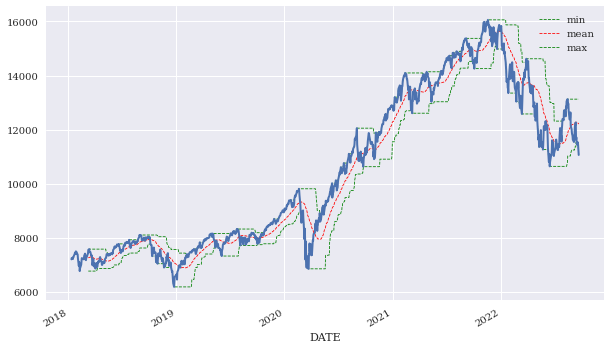

In [60]:
overview(df,'NASDAQCOM',window=40)

In [64]:
def sma_analysis(df,sym,sma1=42,sma2=252):
    # sma1 < sma2 
    df['sma1'] = df[sym].rolling(window=sma1).mean()
    df['sma2'] = df[sym].rolling(window=sma2).mean()
    df['position'] = np.where(df['sma1']>df['sma2'],1,-1)
    
    # plot 
    ax=df[[sym,'sma1','sma2','position']].plot(figsize=(10,6),secondary_y = 'position')
    ax.get_legend().set_bbox_to_anchor((0.25,0.25))
    

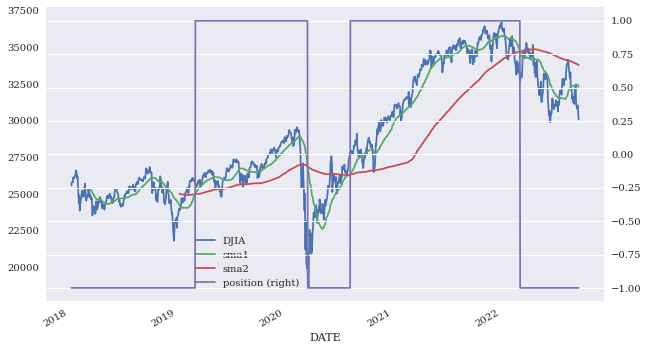

In [96]:
sma_analysis(df,'DJIA',42,252)

In [92]:
def corr_analysis(df,col1,col2):
    cols = [col1,col2]
    pd.plotting.scatter_matrix(df[cols],alpha=0.2,diagonal='hist',hist_kwds={'bins':20},figsize=(10,6))
    reg = np.polyfit(df[col1],df[col2],deg=1)
    ax = df.plot(kind='scatter',x=col1,y=col2,figsize=(10,6))
    ax.plot(df[col1],np.polyval(reg,df[col1]),'r',lw=2);
    # print(df[cols].corr())
    plt.figure()
    ax2=df[col1].rolling(window=252).corr(df[col2]).plot(figsize=(10,6))
    ax2.axhline(df[cols].corr().iloc[0,1],c='r')

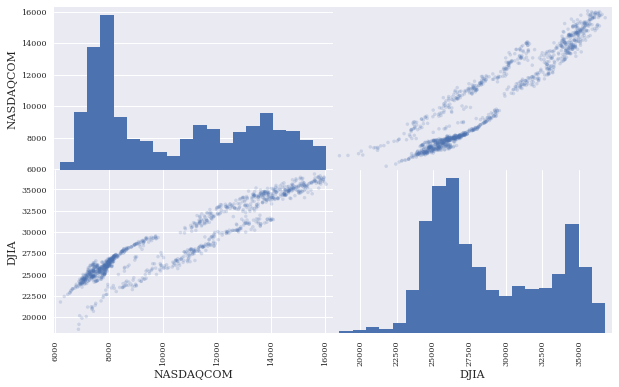

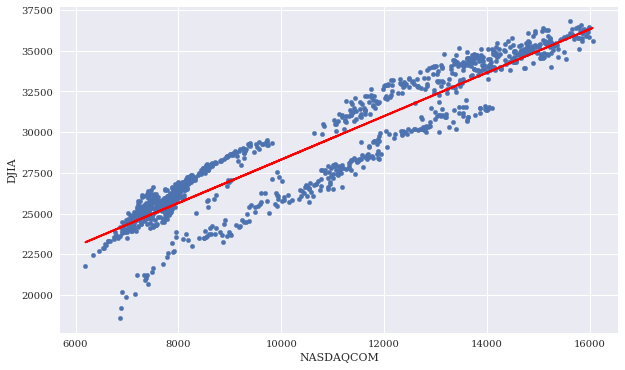

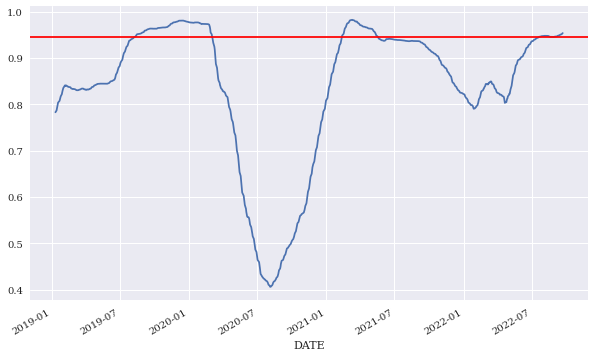

In [93]:
corr_analysis(df,'NASDAQCOM','DJIA')

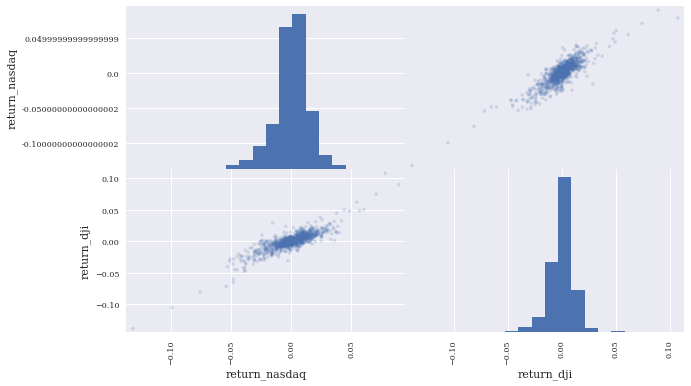

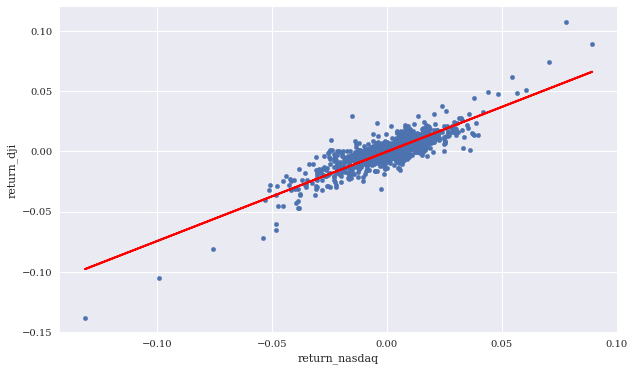

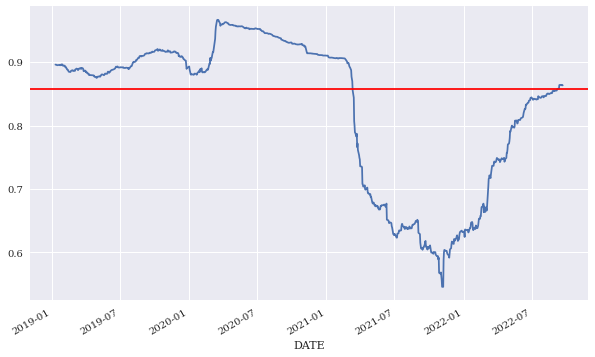

In [94]:
corr_analysis(df,'return_nasdaq','return_dji')